In [1]:
#require "iocaml-kernel" ;;
#require "cairo2" ;;

open Bigarray ;;

/home/opam/.opam/4.04.1/lib/ocaml/unix.cma: loaded
/home/opam/.opam/4.04.1/lib/easy-format: added to search path
/home/opam/.opam/4.04.1/lib/easy-format/easy_format.cmo: loaded
/home/opam/.opam/4.04.1/lib/biniou: added to search path
/home/opam/.opam/4.04.1/lib/biniou/biniou.cma: loaded
/home/opam/.opam/4.04.1/lib/yojson: added to search path
/home/opam/.opam/4.04.1/lib/yojson/yojson.cmo: loaded
/home/opam/.opam/4.04.1/lib/ocaml/str.cma: loaded
/home/opam/.opam/4.04.1/lib/atd: added to search path
/home/opam/.opam/4.04.1/lib/atd/atd.cma: loaded
/home/opam/.opam/4.04.1/lib/atdgen: added to search path
/home/opam/.opam/4.04.1/lib/atdgen/atdgen.cma: loaded
/home/opam/.opam/4.04.1/lib/bytes: added to search path
/home/opam/.opam/4.04.1/lib/result: added to search path
/home/opam/.opam/4.04.1/lib/result/result.cma: loaded
/home/opam/.opam/4.04.1/lib/lwt: added to search path
/home/opam/.opam/4.04.1/lib/lwt/lwt.cma: loaded
/home/opam/.opam/4.04.1/lib/lwt/lwt-log.cma: loaded
/home/opam/.opam/

## Auxiliary routines

In [2]:
let create_rgba_image rgba =
  let height, width = Array3.dim1 rgba, Array3.dim2 rgba in
  let pixels = reshape_1 (genarray_of_array3 rgba) (height * width * 4) in
  Cairo.Image.(create_for_data8 ~stride:(width * 4) pixels RGB24 width height)

let plot_rgba_image rgba =
  Cairo.PNG.write_to_stream ~output:(output_string Iocaml.mime) (create_rgba_image rgba) ;
  Iocaml.send_mime ~base64:true "image/png"

val create_rgba_image :
 (int, Bigarray.int8_unsigned_elt, Bigarray.c_layout) Bigarray.Array3.t ->
 Cairo.Surface.t = <fun>

val plot_rgba_image :
 (int, Bigarray.int8_unsigned_elt, Bigarray.c_layout) Bigarray.Array3.t ->
 unit = <fun>

## Source image

In [3]:
let surface = Cairo.PNG.create "datasets/lenna.png" ;;
let width, height = Cairo.Image.get_width surface, Cairo.Image.get_height surface ;;
let src =
  let data = Array3.create Int8_unsigned C_layout height width 4 in
  let ctx = Cairo.create @@ create_rgba_image data in
  Cairo.set_source_surface ctx surface ~x:0.0 ~y:0.0 ;
  Cairo.paint ctx ;
  data

val surface : Cairo.Surface.t = <abstr>

val width : int = 256
val height : int = 256

val src :
 (int, Bigarray.int8_unsigned_elt, Bigarray.c_layout) Bigarray.Array3.t =
 <abstr>

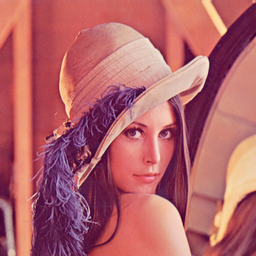

- : unit = ()

In [4]:
Cairo.PNG.write_to_stream surface ~output:(output_string Iocaml.mime) ;
Iocaml.send_mime ~base64:true "image/png"

## Gaussian filter

<table border="1">
  <tr><td>1/16</td><td>2/16</td><td>1/16</td></tr>
  <tr><td>2/16</td><td>4/16</td><td>2/16</td></tr>
  <tr><td>1/16</td><td>2/16</td><td>1/16</td></tr>
</table>

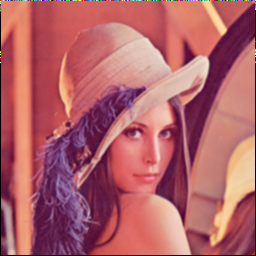

- : unit = ()

In [5]:
let dst = Array3.create Int8_unsigned C_layout width height 4 in
for i = 1 to height - 2 do
  for j = 1 to width - 2 do
    for k = 0 to 3 do
      let z = (    src.{i-1,j+1,k} + 2 * src.{i,j+1,k} +     src.{i+1,j+1,k}
             + 2 * src.{i-1,j  ,k} + 4 * src.{i,j  ,k} + 2 * src.{i+1,j  ,k}
             +     src.{i-1,j-1,k} + 2 * src.{i,j-1,k} +     src.{i+1,j-1,k}) / 16 in
      dst.{i,j,k} <- min (max z 0) 255
    done
  done
done ;
plot_rgba_image dst

## Horizontal sobel filter

<table border="1">
  <tr><td>-1</td><td>0</td><td>+1</td></tr>
  <tr><td>-2</td><td>0</td><td>+2</td></tr>
  <tr><td>-1</td><td>0</td><td>+1</td></tr>
</table>

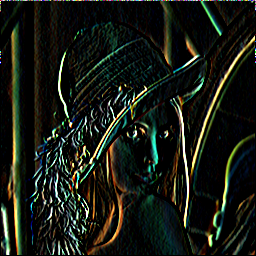

- : unit = ()

In [6]:
let dst = Array3.create Int8_unsigned C_layout width height 4 in
for i = 1 to height - 2 do
  for j = 1 to width - 2 do
    for k = 0 to 3 do
      let z = src.{i-1,j+1,k} + 2 * src.{i,j+1,k} + src.{i+1,j+1,k}
            - src.{i-1,j-1,k} - 2 * src.{i,j-1,k} - src.{i+1,j-1,k} in
      dst.{i,j,k} <- min (max z 0) 255
    done
  done
done ;
plot_rgba_image dst

## Vertical sobel filter

<table border="1">
  <tr><td>-1</td><td>-2</td><td>-1</td></tr>
  <tr><td>0</td><td>0</td><td>0</td></tr>
  <tr><td>+1</td><td>+2</td><td>+1</td></tr>
</table>

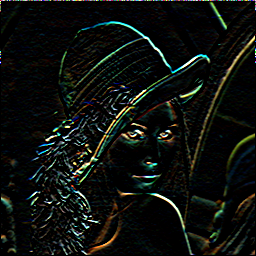

- : unit = ()

In [7]:
let dst = Array3.create Int8_unsigned C_layout width height 4 in
for i = 1 to height - 2 do
  for j = 1 to width - 2 do
    for k = 0 to 3 do
      let z = src.{i+1,j-1,k} + 2 * src.{i+1,j,k} + src.{i+1,j+1,k}
            - src.{i-1,j-1,k} - 2 * src.{i-1,j,k} - src.{i-1,j+1,k} in
      dst.{i,j,k} <- min (max z 0) 255
    done
  done
done ;
plot_rgba_image dst

## Laplacian filter

<table border="1">
  <tr><td>0</td><td>1</td><td>0</td></tr>
  <tr><td>1</td><td>-4</td><td>1</td></tr>
  <tr><td>0</td><td>1</td><td>0</td></tr>
</table>

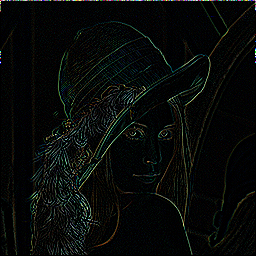

- : unit = ()

In [8]:
let dst = Array3.create Int8_unsigned C_layout width height 4 in
for i = 1 to height - 2 do
  for j = 1 to width - 2 do
    for k = 0 to 3 do
      let z = src.{i,j+1,k} + src.{i-1,j,k} - 4 * src.{i,j,k} + src.{i+1,j,k} + src.{i,j-1,k} in
      dst.{i,j,k} <- min (max z 0) 255
    done
  done
done ;
plot_rgba_image dst